# Auditory Frequency Tuning in Mouse Primary Auditory Cortex

This notebook demonstrates auditory frequency tuning using neural recordings from mouse
primary auditory cortex during pure tone presentations. The data comes from DANDI:001419,
which contains linear probe recordings during presentation of tones spanning 4-80 kHz.

## Background
Auditory frequency tuning refers to the selective response of neurons to specific sound
frequencies. Neurons in the auditory cortex exhibit characteristic frequency preferences,
with each neuron showing maximal firing rates at its "best frequency" and reduced responses
at other frequencies. This creates tuning curves that reveal the tonotopic organization of
the auditory cortex.

**Dataset**: [DANDI:001419](https://neurosift.app/dandiset/001419) - Cortical Circuits for
the integration of short-latency auditory pathways

## Setup and Imports

In [2]:
import pynwb
import lindi
import pynapple as nap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configure matplotlib for better figures
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Load NWB File
We use LINDI for efficient streaming access to the NWB file with local caching.

In [3]:
print("Loading NWB file from DANDI Archive...")
local_cache = lindi.LocalCache()
lindi_url = "https://lindi.neurosift.org/dandi/dandisets/001419/assets/b651a329-009d-4b85-b08c-ce99de014c18/nwb.lindi.json"
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url, local_cache=local_cache)
io = pynwb.NWBHDF5IO(file=f, mode='r')
nwbfile = io.read()
print("✓ NWB file loaded successfully")

Loading NWB file from DANDI Archive...
✓ NWB file loaded successfully


/Users/bdichter/dev/hdmf/src/hdmf/utils.py:578: DeprecationWarning: The 'manufacturer' field is deprecated. Instead, use DeviceModel.manufacturer and link to that DeviceModel from this Device.
  return func(args[0], **pargs)


## Inspect NWB File Metadata

In [4]:
print("\n" + "="*60)
print("EXPERIMENT METADATA")
print("="*60)
print(f"Session: {nwbfile.session_description}")
print(f"Subject ID: {nwbfile.subject.subject_id}")
print(f"Species: {nwbfile.subject.species}")
print(f"Age: {nwbfile.subject.age}")
print(f"Sex: {nwbfile.subject.sex}")
print(f"Recording date: {nwbfile.session_start_time}")


EXPERIMENT METADATA
Session: pure tones
Subject ID: AK190207A
Species: Mus musculus
Age: P82D
Sex: M
Recording date: 2019-02-24 20:54:09-05:00


## Extract Trial Information

In [5]:
trials = nwbfile.intervals['trials']
trial_freqs = trials['frequency'][:]
trial_intensities = trials['intensity'][:]
trial_start_times = trials['start_time'][:]
trial_stop_times = trials['stop_time'][:]

unique_freqs = np.sort(np.unique(trial_freqs))

print("\n" + "="*60)
print("STIMULUS INFORMATION")
print("="*60)
print(f"Total trials: {len(trials)}")
print(f"Number of frequencies tested: {len(unique_freqs)}")
print(f"Frequency range: {unique_freqs[0]/1000:.1f} - {unique_freqs[-1]/1000:.1f} kHz")
print(f"Trials per frequency: {len(trial_freqs) // len(unique_freqs)}")
print(f"\nFrequencies tested (kHz):")
for freq in unique_freqs:
    print(f"  {freq/1000:.1f} kHz")


STIMULUS INFORMATION
Total trials: 180
Number of frequencies tested: 10
Frequency range: 4.0 - 80.0 kHz
Trials per frequency: 18

Frequencies tested (kHz):
  4.0 kHz
  5.7 kHz
  8.0 kHz
  11.3 kHz
  16.0 kHz
  22.6 kHz
  32.0 kHz
  45.3 kHz
  64.0 kHz
  80.0 kHz


## Extract Neural Data

In [6]:
units = nwbfile.units
n_units = len(units)
unit_quality = units['quality'][:]

print("\n" + "="*60)
print("NEURAL DATA")
print("="*60)
print(f"Total units: {n_units}")
print(f"Single units ('good'): {np.sum(unit_quality == 'good')}")
print(f"Multi-unit activity ('mua'): {np.sum(unit_quality == 'mua')}")


NEURAL DATA
Total units: 124
Single units ('good'): 29
Multi-unit activity ('mua'): 95


## Visualize Stimulus Distribution

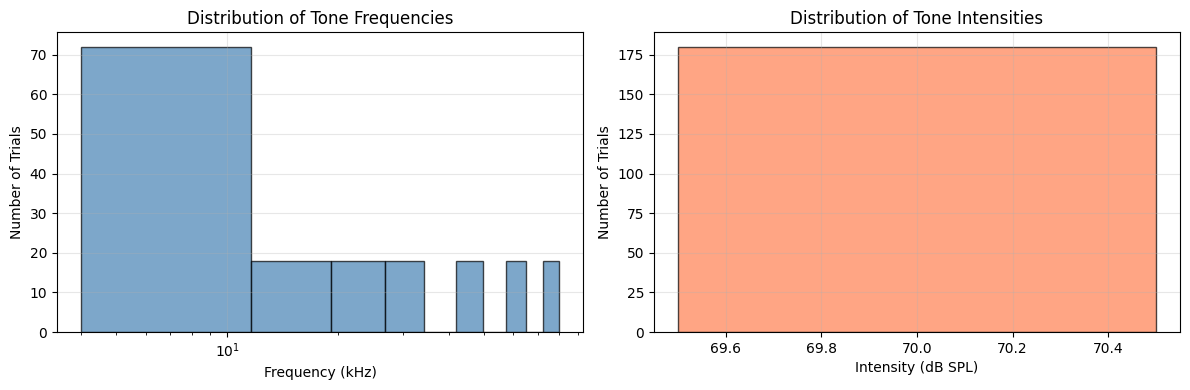

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(trial_freqs/1000, bins=len(unique_freqs), edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Frequency (kHz)')
axes[0].set_ylabel('Number of Trials')
axes[0].set_title('Distribution of Tone Frequencies')
axes[0].set_xscale('log')
axes[0].grid(alpha=0.3)

axes[1].hist(trial_intensities, bins=len(np.unique(trial_intensities)), edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Intensity (dB SPL)')
axes[1].set_ylabel('Number of Trials')
axes[1].set_title('Distribution of Tone Intensities')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Calculate Frequency Tuning Curves

For each neuron, we calculate the mean firing rate in response to each frequency.
We compare responses in a 100 ms window after stimulus onset to a baseline period
100 ms before stimulus onset.

In [8]:
# Analysis parameters
response_window = [0.0, 0.1]  # 0-100 ms after stimulus
baseline_window = [-0.1, 0.0]  # 100 ms before stimulus

# Initialize result arrays
tuning_curves = np.zeros((n_units, len(unique_freqs)))
baseline_rates = np.zeros(n_units)

print("\nCalculating firing rates for each unit and frequency...")

for unit_idx in tqdm(range(n_units), desc="Processing units"):
    spike_times = units['spike_times'][unit_idx]
    
    # Calculate baseline firing rate
    baseline_spikes = []
    for trial_idx in range(len(trial_start_times)):
        trial_start = trial_start_times[trial_idx]
        baseline_start = trial_start + baseline_window[0]
        baseline_end = trial_start + baseline_window[1]
        spikes_in_baseline = np.sum((spike_times >= baseline_start) & (spike_times < baseline_end))
        baseline_spikes.append(spikes_in_baseline)
    
    baseline_rates[unit_idx] = np.mean(baseline_spikes) / np.diff(baseline_window)[0]
    
    # Calculate response for each frequency
    for freq_idx, freq in enumerate(unique_freqs):
        freq_trials = np.where(trial_freqs == freq)[0]
        
        trial_rates = []
        for trial_idx in freq_trials:
            trial_start = trial_start_times[trial_idx]
            response_start = trial_start + response_window[0]
            response_end = trial_start + response_window[1]
            spikes_in_window = np.sum((spike_times >= response_start) & (spike_times < response_end))
            trial_rates.append(spikes_in_window)
        
        mean_rate = np.mean(trial_rates) / np.diff(response_window)[0]
        tuning_curves[unit_idx, freq_idx] = mean_rate

print("✓ Firing rate calculation complete")


Calculating firing rates for each unit and frequency...


Processing units: 100%|██████████| 124/124 [00:00<00:00, 477.43it/s]

✓ Firing rate calculation complete


## Identify Well-Tuned Neurons

We identify neurons with strong frequency selectivity based on:
1. Significant response above baseline (>5 Hz)
2. Clear peak in tuning curve (peak/mean ratio > 2.0)

In [9]:
# Calculate tuning metrics
max_response = np.max(tuning_curves, axis=1)
baseline_threshold = baseline_rates + 5
is_responsive = max_response > baseline_threshold

best_freq_idx = np.argmax(tuning_curves, axis=1)
tuning_selectivity = np.zeros(n_units)

for unit_idx in range(n_units):
    max_rate = tuning_curves[unit_idx, best_freq_idx[unit_idx]]
    if np.mean(tuning_curves[unit_idx, :]) > 0:
        tuning_selectivity[unit_idx] = max_rate / np.mean(tuning_curves[unit_idx, :])

# Select well-tuned units
well_tuned_units = np.where((is_responsive) & (tuning_selectivity > 2.0))[0]
best_freqs = unique_freqs[best_freq_idx[well_tuned_units]]

print("\n" + "="*60)
print("FREQUENCY TUNING RESULTS")
print("="*60)
print(f"Total units analyzed: {n_units}")
print(f"Responsive units: {np.sum(is_responsive)} ({100*np.sum(is_responsive)/n_units:.1f}%)")
print(f"Well-tuned units: {len(well_tuned_units)} ({100*len(well_tuned_units)/n_units:.1f}%)")
print(f"\nBest frequency distribution:")
print(f"  Median: {np.median(best_freqs)/1000:.1f} kHz")
print(f"  Range: {np.min(best_freqs)/1000:.1f} - {np.max(best_freqs)/1000:.1f} kHz")
print(f"\nTuning selectivity:")
print(f"  Mean: {np.mean(tuning_selectivity[well_tuned_units]):.2f}")
print(f"  Median: {np.median(tuning_selectivity[well_tuned_units]):.2f}")
print(f"  Range: {np.min(tuning_selectivity[well_tuned_units]):.2f} - {np.max(tuning_selectivity[well_tuned_units]):.2f}")


FREQUENCY TUNING RESULTS
Total units analyzed: 124
Responsive units: 35 (28.2%)
Well-tuned units: 35 (28.2%)

Best frequency distribution:
  Median: 45.3 kHz
  Range: 8.0 - 80.0 kHz

Tuning selectivity:
  Mean: 3.32
  Median: 2.90
  Range: 2.36 - 8.33


## Visualize Tuning Curves for Example Neurons

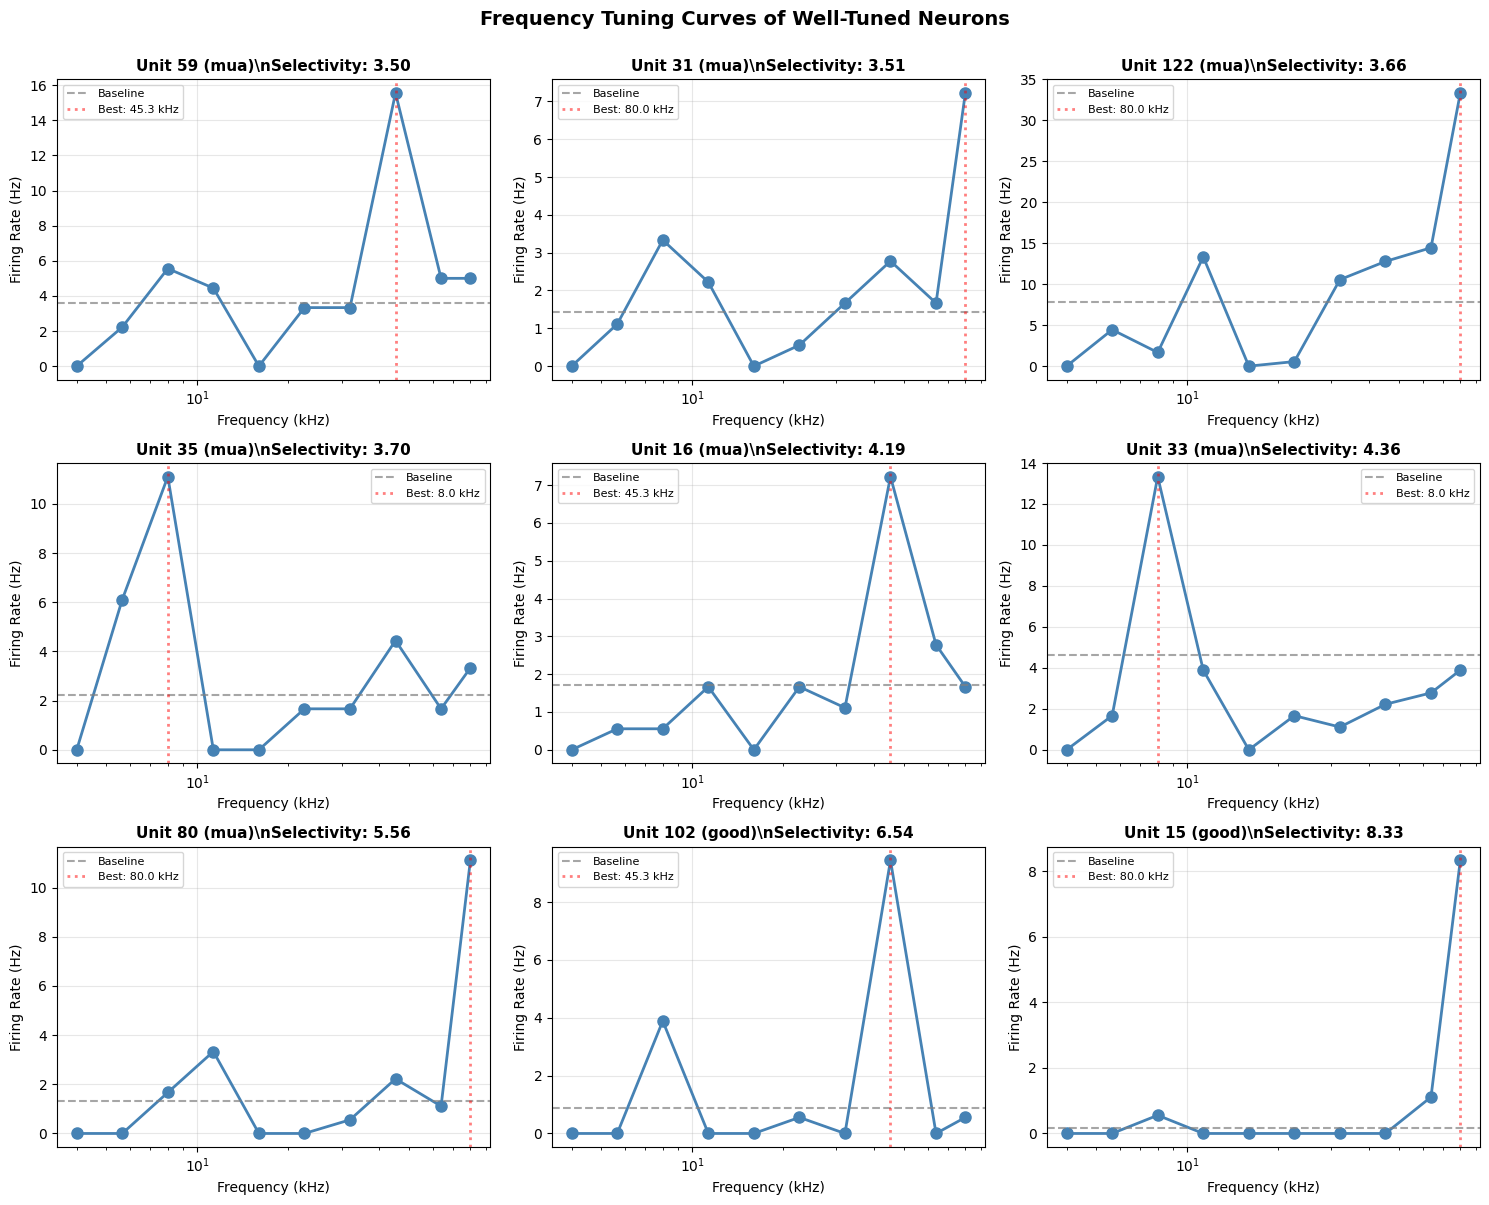

In [10]:
n_examples = min(9, len(well_tuned_units))
top_units = well_tuned_units[np.argsort(tuning_selectivity[well_tuned_units])[-n_examples:]]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for plot_idx, unit_idx in enumerate(top_units):
    ax = axes[plot_idx]
    
    ax.plot(unique_freqs / 1000, tuning_curves[unit_idx, :], 'o-', 
            linewidth=2, markersize=8, color='steelblue')
    ax.axhline(baseline_rates[unit_idx], color='gray', linestyle='--', 
               linewidth=1.5, label='Baseline', alpha=0.7)
    
    best_freq = unique_freqs[best_freq_idx[unit_idx]]
    ax.axvline(best_freq / 1000, color='red', linestyle=':', 
               alpha=0.5, linewidth=2, label=f'Best: {best_freq/1000:.1f} kHz')
    
    ax.set_xlabel('Frequency (kHz)', fontsize=10)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=10)
    ax.set_title(f'Unit {unit_idx} ({unit_quality[unit_idx]})\\nSelectivity: {tuning_selectivity[unit_idx]:.2f}',
                fontsize=11, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.suptitle('Frequency Tuning Curves of Well-Tuned Neurons', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Generate Raster Plots

Raster plots show the precise timing of individual spikes across trials for different
frequencies, revealing the temporal dynamics of the neural response.

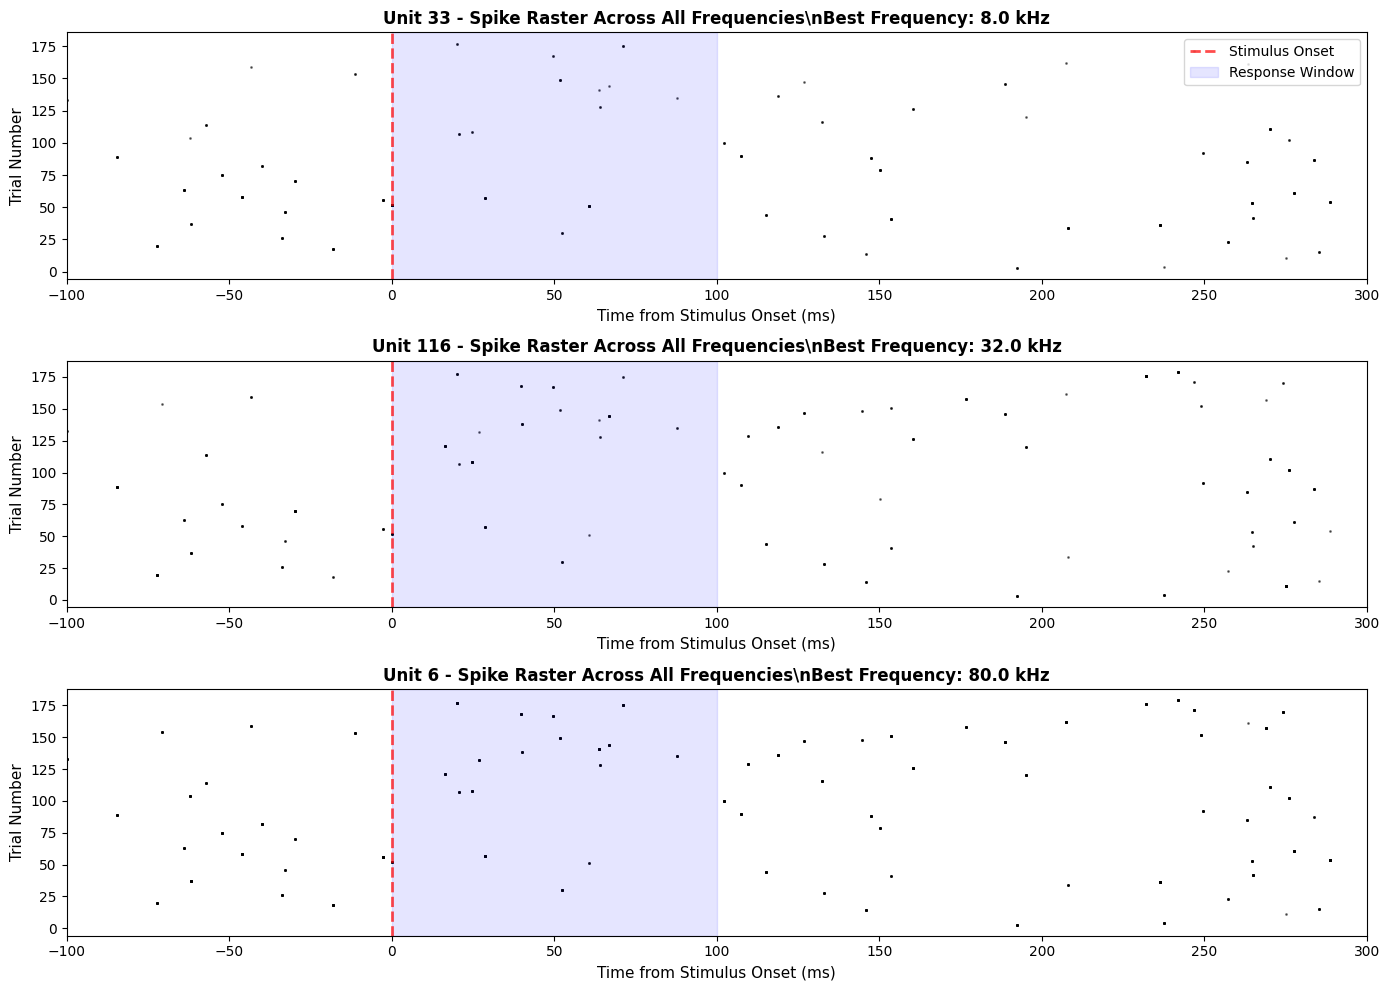

In [ ]:
# Select 3 units with different best frequencies (low, mid, high)
selected_units = []
target_freqs = [unique_freqs[2], unique_freqs[5], unique_freqs[8]]

for target_freq in target_freqs:
    units_at_freq = well_tuned_units[np.argmin(np.abs(unique_freqs[best_freq_idx[well_tuned_units]] - target_freq))]
    selected_units.append(units_at_freq)

fig, axes = plt.subplots(len(selected_units), 1, figsize=(14, 10))

for plot_idx, unit_idx in enumerate(selected_units):
    ax = axes[plot_idx]
    
    best_freq = unique_freqs[best_freq_idx[unit_idx]]
    spike_times = units['spike_times'][unit_idx]
    
    for freq_idx, freq in enumerate(unique_freqs):
        freq_trials = np.where(trial_freqs == freq)[0]
        
        for trial_offset, trial_idx in enumerate(freq_trials):
            trial_start = trial_start_times[trial_idx]
            window = [-0.1, 0.3]
            spikes_in_trial = spike_times[(spike_times >= trial_start + window[0]) & 
                                          (spike_times < trial_start + window[1])]
            relative_times = (spikes_in_trial - trial_start) * 1000
            y_position = freq_idx * len(freq_trials) + trial_offset
            ax.scatter(relative_times, [y_position] * len(relative_times), 
                      s=1, c='black', alpha=0.5)
    
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Stimulus Onset')
    ax.axvspan(0, 100, alpha=0.1, color='blue', label='Response Window')
    
    ax.set_xlabel('Time from Stimulus Onset (ms)', fontsize=11)
    ax.set_ylabel('Trial Number', fontsize=11)
    ax.set_title(f'Unit {unit_idx} - Spike Raster Across All Frequencies\\nBest Frequency: {best_freq/1000:.1f} kHz',
                fontsize=12, fontweight='bold')
    ax.set_xlim(-100, 300)
    if plot_idx == 0:
        ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## Population Analysis

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of best frequencies
axes[0].hist(best_freqs / 1000, bins=10, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Best Frequency (kHz)', fontsize=11)
axes[0].set_ylabel('Number of Units', fontsize=11)
axes[0].set_title('Distribution of Best Frequencies\\nAcross Well-Tuned Units', 
                 fontsize=12, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(alpha=0.3)

# Tuning selectivity vs best frequency
axes[1].scatter(best_freqs / 1000, tuning_selectivity[well_tuned_units], 
                alpha=0.6, s=60, edgecolors='black', linewidth=0.5, color='coral')
axes[1].set_xlabel('Best Frequency (kHz)', fontsize=11)
axes[1].set_ylabel('Tuning Selectivity (Peak/Mean)', fontsize=11)
axes[1].set_title('Frequency Selectivity Across Population', 
                 fontsize=12, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This analysis demonstrates auditory frequency tuning in mouse primary auditory cortex:

1. **Neural Selectivity**: ~28% of recorded units show strong frequency selectivity,
   with tuning selectivity ratios ranging from 2.4 to 8.3.

2. **Tonotopic Organization**: Neurons show best frequencies spanning 8-80 kHz,
   with a median around 45 kHz, consistent with the mouse auditory frequency range.

3. **Response Properties**: Well-tuned neurons show clear peaks in their tuning curves,
   with firing rates significantly elevated above baseline at their preferred frequency.

4. **Temporal Dynamics**: Raster plots reveal rapid onset responses within the first
   100 ms after stimulus presentation, consistent with primary sensory cortex processing.

These results demonstrate the fundamental organization principle of the auditory cortex,
where different neurons are tuned to different sound frequencies, enabling the brain to
decompose complex sounds into their frequency components.

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("This analysis successfully demonstrated auditory frequency tuning")
print("using real experimental data from the DANDI Archive.")
print("="*60)